<a href="https://colab.research.google.com/github/fatenchtioui/AD/blob/main/EX_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import Lib

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten

# Connect to Google Drive (optional)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load dataset

In [ ]:

dataset_path = '/content/drive/MyDrive/Colab Notebooks/train_cancer'

In [ ]:

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(

    dataset_path,
    target_size=(224, 224), #The size to which all images will be resized.
    batch_size=batch_size,
    class_mode='binary', #Since this is a Binary classification. For multiple classes classification, 'categorical' is chosen.
    subset='training' # Indicates that this is the training subset of the data.
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 224 images belonging to 2 classes.
Found 56 images belonging to 2 classes.


#  VGG16 model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze the VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #loss='categorical_crossentropy' for multiclass classification
    metrics=['accuracy'])

In [ ]:
# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 21137729 (80.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
epochs = 3
#After training is complete, the fit method returns a History object. This object contains information about the training process,
#such as training loss, training accuracy, validation loss, and validation accuracy at each epoch.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    #In Keras, during the training process, one epoch is completed when the model has iterated over the entire training dataset once.
    #However, the dataset is not processed in its entirety at once but rather in batches.
    #steps_per_epoch specifies the number of batches to go through before considering one epoch finished.
    #It's a way to define when to move to the next epoch during training.
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/3
7/7 [==============================] - 529s 75s/step - loss: 3.3834 - accuracy: 0.7902 - val_loss: 0.2776 - val_accuracy: 0.9688
Epoch 2/3
7/7 [==============================] - 500s 72s/step - loss: 0.4727 - accuracy: 0.8304 - val_loss: 0.4943 - val_accuracy: 0.8750
Epoch 3/3
7/7 [==============================] - 506s 72s/step - loss: 0.3723 - accuracy: 0.8929 - val_loss: 0.4736 - val_accuracy: 0.8750


In [ ]:
score = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

1/1 [==============================] - 20s 20s/step - loss: 0.2552 - accuracy: 0.9375
Test Loss: 0.2551892399787903, Test Accuracy: 0.9375


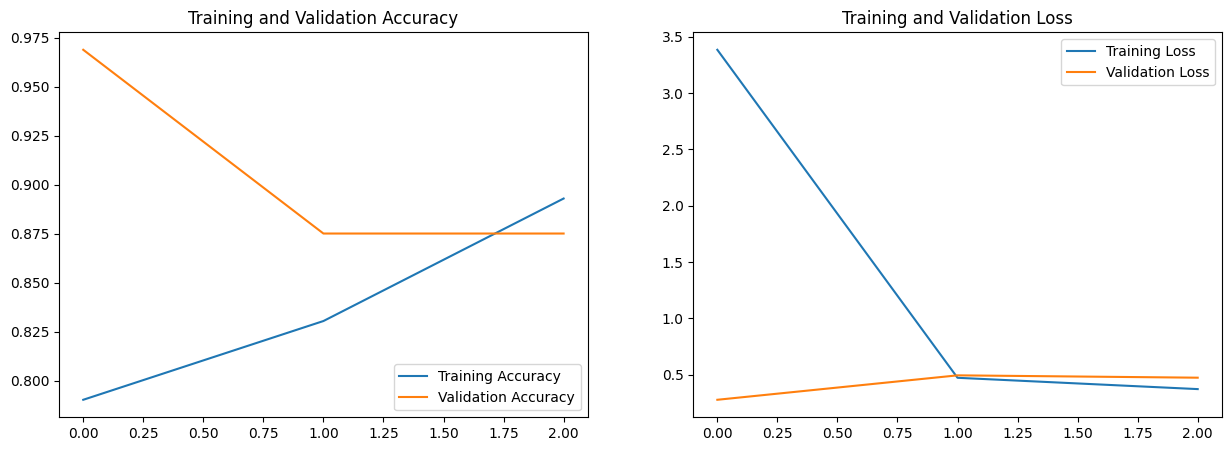

In [ ]:
# Plot the training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# CNN Model

In [ ]:
# Construction du modèle CNN
input_shape = (28, 28, 1)
input_cnn = Input(shape=input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu')(input_cnn)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
flatten = Flatten()(maxpool2)
dense_cnn = Dense(128, activation='relu')(flatten)


In [ ]:
from tensorflow.keras.optimizers import Adam
# Compilation du modèle
# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
# Entraînement du modèle
history = dense_cnn.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Évaluation du modèle
test_loss, test_acc = dense_cnn.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {test_acc * 100:.2f}%")

AttributeError: ignored

In [ ]:
# Display model summary
model.summary()

In [ ]:
# creation CNN & VGG16
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = model.outpu(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:



# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

